In [1]:
import pydicom
from matplotlib import pyplot as plt
import numpy as np
from skimage import exposure, io
import cv2 as cv

# Leemos los datos de la imagen DICOM

Patient's Name: BRAVO FLORES^EYERAHI
Patient ID: D19158-17-10-02-1
Modality: US
Study Date: 20180130
Row Spacing (mm): 0.121614
Column Spacing (mm): 0.121614
Image dimensions: (720, 960, 3)


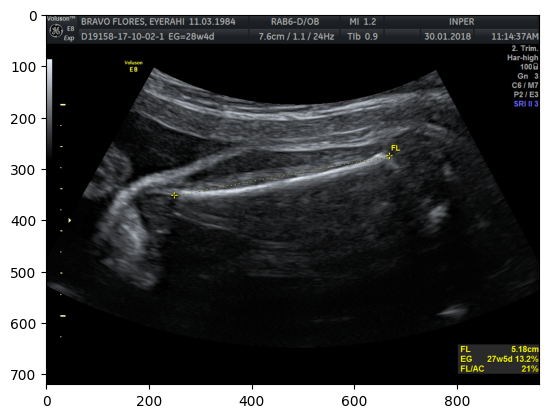

In [2]:
filename = '/home/daniel/Documents/Proyectos/All_femur/tercer_trim/IM17.dcm'
ds = pydicom.dcmread(filename)
print(f"Patient's Name: {ds.PatientName}")
print(f"Patient ID: {ds.PatientID}")
print(f"Modality: {ds.Modality}")
print(f"Study Date: {ds.StudyDate}")
pixel_spacing = ds.PixelSpacing
row_spacing, column_spacing = pixel_spacing
print(f"Row Spacing (mm): {row_spacing}")
print(f"Column Spacing (mm): {column_spacing}")
# Access the pixel array
image_data = ds.pixel_array

# The 'pixel_array' attribute is a NumPy array containing the image pixel data
print(f"Image dimensions: {image_data.shape}")
# Display the image using matplotlib
plt.imshow(image_data, cmap='gray')  # 'gray' is often used for medical images
plt.show()

# Sacamos las dimensiones de la imagen y hacermos el crop automatico

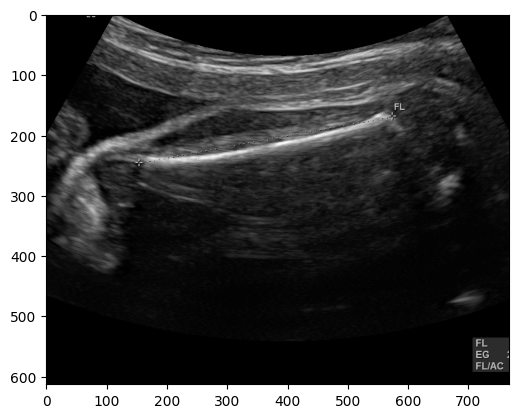

In [3]:
if image_data.shape[2]==3:
    img = cv.cvtColor(image_data, cv.COLOR_BGR2GRAY)
else:
    img  = image_data
# Assuming 'img' is the grayscale image loaded earlier with OpenCV
DIM = img.shape  # Get the dimensions of the image

# Calculate crop dimensions
X = int(DIM[1] * 0.1)  # 10% of the columns on the right
Y = int(DIM[0] * 0.15)  # 15% of the rows from the top
X2 = int(DIM[1] - DIM[1] * 0.1)  # Remaining 90% of the columns, to crop 10% from the left

# Crop the image
# Note: In OpenCV, image dimensions are accessed as rows (height) and cols (width),
# so the order in slicing is img[y1:y2, x1:x2]
cropped_img = img[Y-1:DIM[0], X:X2]
plt.imshow(cropped_img,cmap='gray')


# Pre-procesamiento Filtrado, Operaciones morfologicas, Resta, Segunda operacion morfologica, Umbral OTSU seccional

## Fitro Anisotropico

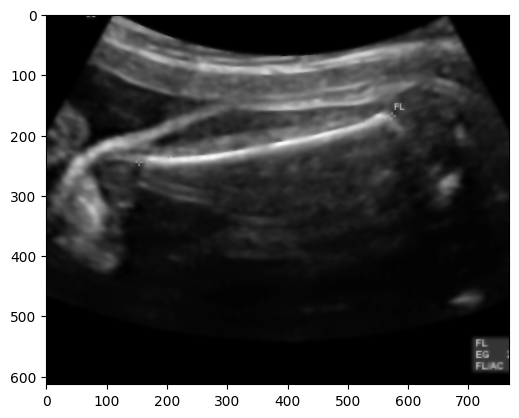

In [4]:
import difussionFilter
diffusied_image = difussionFilter.anisodiff(cropped_img,niter=20,kappa=30,gamma=0.25,option=2)
plt.imshow(diffusied_image,cmap='gray')
diffused_image = diffusied_image.astype(np.uint8)
plt.imshow(diffused_image,cmap='gray')

## Alargamiento del Histograma

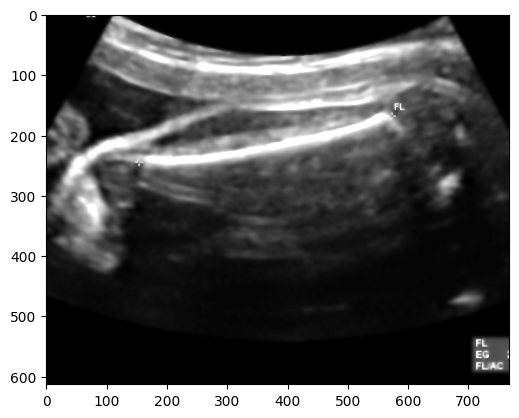

In [5]:
# Assuming filt_img is your filtered image loaded as a NumPy array
# If filt_img is not loaded, you can load it using skimage.io.imread()

# Calculate the percentile values for the lower and upper bounds, similar to MATLAB's stretchlim
# Note: stretchlim in MATLAB defaults to 0.01 to 0.99 percentiles. Adjust p2 and p98 as needed.
p2, p98 = np.percentile(diffused_image, (2, 98))
img_rescaled = exposure.rescale_intensity(diffused_image, in_range=(p2, p98))
plt.imshow(img_rescaled,cmap='gray')

## Primera Operacion morfologica y Resta

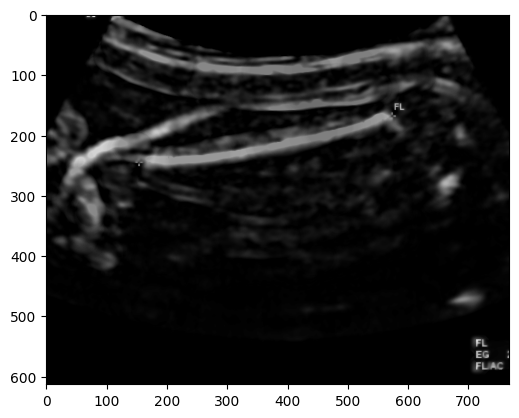

In [6]:
from skimage.morphology import opening, disk
# Create a structuring element (SE) with a disk shape of size 25
selem = disk(25)
# Perform the grayscale opening
img_open = opening(img_rescaled, selem)
# Subtract the opened image from the original (contrast-stretched) image
imsubclos = img_rescaled - img_open
plt.imshow(imsubclos,cmap='gray')

### Segunda opreacion morfologica (cierre)

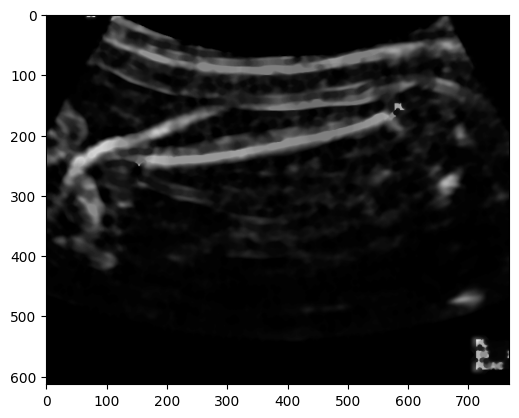

In [7]:
from skimage.morphology import closing, disk

# Create a second structuring element (SE) with a disk shape of size 4
selem = disk(4)

# Perform the morphological closing on the subtracted image
imsubclos = closing(imsubclos, selem)
plt.imshow(imsubclos,cmap='gray')

### Binarizacion con OTSU

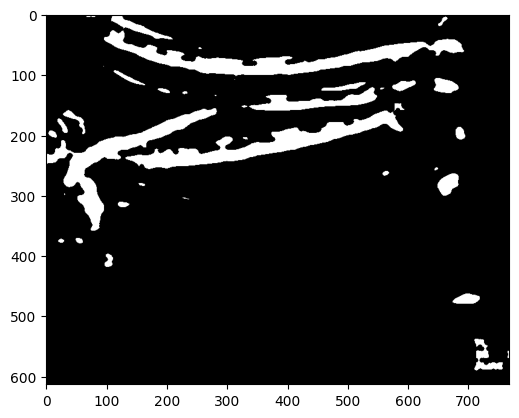

In [8]:
from skimage.filters import threshold_otsu

# Assuming imsubclos is your pre-processed image

# Get the dimensions of the image
dim = imsubclos.shape
X = int(dim[0] * 0.5)
Y = int(dim[1] * 0.5)

# Divide the image into four sections
crop1 = imsubclos[:X, :Y]        # First section
crop2 = imsubclos[:X, Y:]        # Second section
crop3 = imsubclos[X:, :Y]        # Third section
crop4 = imsubclos[X:, Y:]        # Fourth section

# Calculate the Otsu threshold for the whole image and each section
T = threshold_otsu(imsubclos)
T1 = threshold_otsu(crop1)
T2 = threshold_otsu(crop2)
T3 = threshold_otsu(crop3)
T4 = threshold_otsu(crop4)

# Collect all thresholds and select the maximum
thresholds = [T, T1, T2, T3, T4]
max_threshold = max(thresholds)
binary_image = imsubclos > max_threshold
plt.imshow(binary_image,cmap='gray')


### Tercera operacion morfologica 

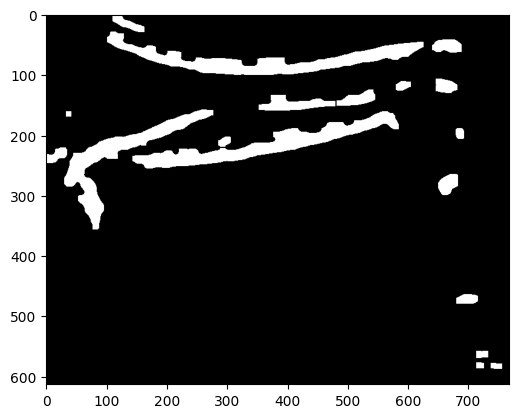

In [9]:
from skimage.morphology import opening, square

# Assuming binary_image is your binary image from the previous Otsu thresholding

# Create a square structuring element with size 9
selem = square(9)

# Perform the morphological opening on the binary image
open_bin = opening(binary_image, selem)
plt.imshow(open_bin,cmap='gray')

### Etiquetar las regiones

In [10]:
from skimage.measure import label, regionprops
# Assuming open_bin is your cleaned binary image
# Label the connected components
labels = label(open_bin)

### Calcular propiedades (Intensidad Media, Centroide, Longitud, Entropia)

In [11]:
import math
# Assuming labels is the labeled image from previous steps
# dim is the dimensions of the original image
# Calculate the maximum possible length in the image
max_L = math.sqrt((dim[0]-1)**2 + (dim[1]-1)**2)

# Lists to store lengths and coordinates of region endpoints
lengths = []
X1, X2, Y1, Y2 = [], [], [], []

# Lists for small regions and candidate (large) regions
small_regions = []
candidate_regions = []

# Loop through each region in the labeled image
for region in regionprops(labels):
    # Extract the row and column coordinates of all pixels in the region
    coords = region.coords
    # Calculate the bounding box of the region to get extreme points
    minr, minc, maxr, maxc = region.bbox
    # Store the coordinates of the endpoints
    X1.append(minr)
    Y1.append(minc)
    X2.append(maxr)
    Y2.append(maxc)
    # Calculate the distance between the endpoints
    dist = np.sqrt((minr - maxr) ** 2 + (minc - maxc) ** 2)
    
    # Check if the region is large enough to be considered a candidate
    if dist > (max_L * 0.1):
        lengths.append(dist)
        candidate_regions.append(region.label)
    else:
        small_regions.append(region.label)

# Remove small regions from the labels image
for label in small_regions:
    labels[labels == label] = 0
# Now, labels is an array where each pixel value represents the label of the connected component it belongs to.
# To calculate properties of these labeled regions:
props = regionprops(labels, intensity_image=img_rescaled)    
# Intesidad Media
I_region = [prop.intensity_mean for prop in props]
# Centroide de la region
centroid_region = [prop.centroid for prop in props]
# Maximo numero de regiones
max_labels = len(I_region)

### Entropia

In [12]:
from matplotlib.pyplot import hist

# Assuming im_adj is the adjusted image from previous steps
# and labels contains the labeled regions after removing the small ones

entropies = []
texture = []

# Loop through each candidate region
for region_label in candidate_regions:
    # Create a mask for the current region
    mask = labels == region_label
    # Apply the mask to the adjusted image
    region_image = np.where(mask, img_rescaled, 0)

    # Normalize the region image if necessary
    region_image = region_image / np.max(region_image)

    # Calculate the histogram of the region image, excluding the background (0 values)
    histogram, _ = np.histogram(region_image[region_image > 0], bins=256, range=(1, np.max(region_image)))
    # Convert histogram to probability distribution
    p = histogram / np.sum(histogram)
    # Remove zeros to avoid log(0) and compute entropy
    p = p[p > 0]
    H = -np.sum(p * np.log2(p))
    entropies.append(H)

# Calculate texture as the inverse of entropy
texture = [1 / H for H in entropies]

## Seleccion de la region candidata a ser Femur

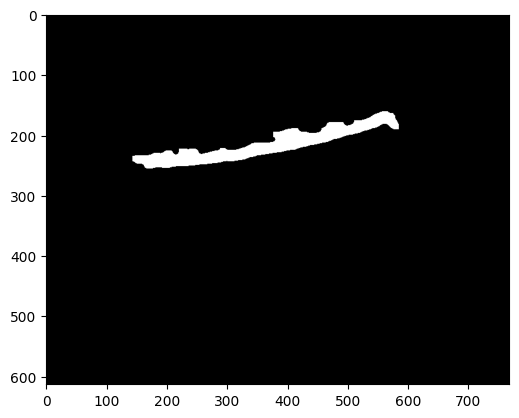

In [13]:
# Assuming 'I_region', 'longitud', 'centroid_region', and 'textura' are already defined
# Also assuming 'candidate_regions' is a list of candidate region labels
# 'labels' is the labeled image where each region is marked with its label

# Calculate scores for each region
centroid_region = np.array(centroid_region)
scores = []
for k in range(len(lengths)):
    score = (1/4) * ((I_region[k] / max(I_region)) +
                     (lengths[k] / max(lengths)) +
                     (centroid_region[k, 0] / max(centroid_region[:, 0])) +
                     (texture[k] / max(texture)))
    scores.append(score)

# Identify the region with the highest score
femur_loc_index = np.argmax(scores)  # Index of the femur location in the candidate_regions list
femur_loc = candidate_regions[femur_loc_index]  # The label of the femur location

# Merging similar regions
# Intensity limit
intensity_limit = I_region[femur_loc_index] - 10
# Centroid position limit
centroid_limit = np.abs(centroid_region[:, 0] - centroid_region[femur_loc_index, 0])

# Find regions with similar characteristics
regions_i = [i for i in range(len(I_region)) if I_region[i] > intensity_limit]
centroids_i = [i for i in range(len(centroid_region)) if centroid_limit[i] < 10]

# If there are regions that meet both criteria, merge them
similar_regions = set(regions_i).intersection(set(centroids_i))
for region_index in similar_regions:
    region_label = candidate_regions[region_index]
    labels[labels == region_label] = femur_loc  # Merge by setting their labels to the femur location label

mask = labels == femur_loc
plt.imshow(mask, cmap='gray')

### Analisis de los extremos

In [14]:
import numpy as np
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
# Find the coordinates of the mask
y, x = np.where(mask)

# Find extrema points
min_x, max_x = np.min(x), np.max(x)
min_y, max_y = np.min(y), np.max(y)

p1_compensado = min_x, y[np.argmin(x)]
p2_compensado = max_x, y[np.argmax(x)]

# Thining of the mask image
skeleton = skeletonize(mask)
# Find coordinates of the thinned (skeletonized) region
r, c = np.where(skeleton)
# Original extremal points
p2 =  c[0], r[0]
p1 = c[-1],r[-1]
compP1, compP2 = abs(p1[0] - p1_compensado[0]), abs(p2[0] - p2_compensado[0])



In [23]:
extrema_points

{'left_or': (143, 235),
 'right_or': (583, 182),
 'left_thined': (184, 243),
 'right_thined': (557, 172),
 'left_comp': (143, 243),
 'right_comp': (583, 172)}

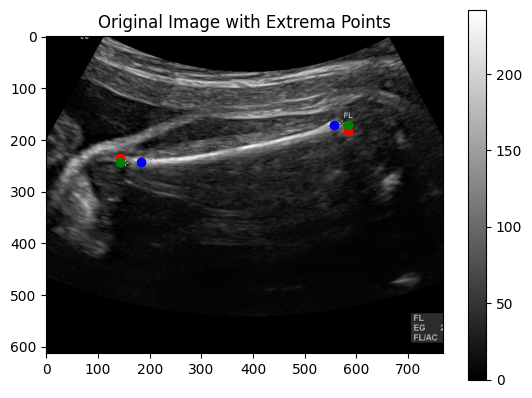

In [15]:
# Plot the original image
extrema_points = {
    "left_or": p1_compensado,
    "right_or": p2_compensado,
    "left_thined": p1,
    "right_thined": p2,
    "left_comp": (p1[0]-compP1,p1[1]),
    "right_comp": (p2[0]+compP2,p2[1])

}

plt.imshow(cropped_img, cmap='gray')
plt.colorbar()

# Plot the extrema points over the original image
for i,point in enumerate(extrema_points.values()):
    if i<=1:
        plt.scatter(point[0], point[1], color='red')
    elif i<=3:
        plt.scatter(point[0], point[1], color='blue')
    else:
        plt.scatter(point[0], point[1], color='green')

plt.title('Original Image with Extrema Points')
plt.show()